In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors as mcolors
from scipy import interpolate
import matplotlib.cm
import pandas as pd
import numpy as np

In [2]:
def section_plot(df,column,title = 'GIVE ME A TITLE!',section_axis = "X", interp = "cubic"):
    gridsize = 100
    fig, ax = plt.subplots(3,3,figsize=(12,12))
    clr_min = df[column].min()
    clr_max = df[column].max()

    xx = np.linspace(df['Y'].min(),df['Y'].max(),gridsize)
    yy = np.linspace(df['Z'].min(),df['Z'].max(),gridsize)
    xi,yi = np.meshgrid(xx,yy)
    if(section_axis=="Y"):
        X = "Z"
        Y = "X"
        Z = "Y"
    elif(section_axis=="Z"):
        X = "X"
        Y = "Y"
        Z = "Z"
    else:
        X = "Y"
        Y = "Z"
        Z = "X"
    for i in range(9):
        zdat = df[df[Z] == df[Z].quantile(0.1+0.1*i+1e-6)]
        zdat = zdat.dropna()
        xdat = zdat[X]
        ydat = zdat[Y]

        dist_from_center = zdat[Z].mean()

        zdat = np.array(zdat[column])
        xdat = np.array(xdat)
        ydat = np.array(ydat)

        zi = interpolate.griddata((xdat,ydat),zdat,(xi[None,:],yi[None,:]),method=interp)[0]
        contour = ax[i//3][i%3].contourf(xi,yi,zi,200,cmap=plt.cm.jet,vmin=clr_min,vmax=clr_max)
        ax[i//3][i%3].set_title("{} = {:.1f} cm".format(Z,dist_from_center*100))

    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85,0.15,0.05,0.7])
    cbar = mpl.colorbar.ColorbarBase(cax,cmap=plt.cm.jet,norm=mpl.colors.Normalize(clr_min,clr_max))
    plt.suptitle(title,fontsize = 25)
    plt.show()

### Convert scan data to be consistent in units with field programs

In [3]:
in_to_m = 2.54e-2
#x0 = np.array([9100.,1200.,175500.])
x0 = np.array([9100.,12000.,-183000.])
step = np.array([9.7960e-04, 7.7690e-04, 6.0000e-05])
step *= in_to_m
orig = np.array([x0[i]*step[i] for i in range(3)])
point = 3
labels_dict = {1:"X",2:"Y",3:"Z",4:"BX",5:"BY",6:"BZ"}


In [4]:
orig*1e2

array([ 22.6424744,  23.679912 , -27.8892   ])

In [5]:
step*1e2

array([0.00248818, 0.00197333, 0.0001524 ])

In [9]:
# this is the unused magnet scan that hasn't been run through Chicago's code

# convert scan data and save to new file
scan_df = pd.read_csv("data/test_scan_18x18x20_wbuffer.csv",header=None)
scan2_df = pd.read_csv("data/test_scan_18x18x20_wbuffer2.csv",header=None)
scan_df = pd.concat([scan_df,scan2_df])
scan_df = scan_df.drop([0,7],axis=1)
scan_df = scan_df.reset_index(drop=True)
for index,row in scan_df.iterrows():
     if(index%3 != 0):
         scan_df = scan_df.drop(index)
scan_df = scan_df.reset_index(drop=True)
for i in range(1,4):
    scan_df[i] *= step[i-1]
    #print("mean = ",scan_df[i].mean())
    #scan_df[i] -= scan_df[i].mean()
    
    scan_df[i] -= orig[i-1]
for i in range(4,7):
    scan_df[i] *= 1.e-4
scan_df = scan_df.rename(index=str, columns=labels_dict)
hold_col = -1.0*scan_df['BY']
scan_df['BY'] = scan_df['BX']
scan_df['BX'] = hold_col


# There are some obviously bad measurements (28 tesla? ha!) in the BZ direction. This puts it in line with the BY measurements.
scan_df = scan_df[np.abs(scan_df['BZ']) < 1]

# add column for the magnitude of the field
scan_df['B'] = np.sqrt(scan_df['BX']*scan_df['BX']+scan_df['BY']*scan_df['BY']+scan_df['BZ']*scan_df['BZ'])

scan_df.to_csv(path_or_buf="data/test_scan_18x18x20_wbuffer12_formatted.csv", header=None,index=False)
scan_df.describe()

,X,Y,Z,BX,BY,BZ,B
count,10977.000000,10977.000000,10977.000000,10977.000000,10977.000000,10977.000000,10977.000000
mean,-0.002494,-0.019767,0.025150,0.842561,0.009216,-0.008744,0.925974
std,0.109730,0.106335,0.150427,0.327864,0.233234,0.303295,0.326358
min,-0.181637,-0.193386,-0.228600,0.076660,-0.827600,-0.864500,0.233636
25%,-0.092063,-0.106560,-0.105156,0.599900,-0.109580,-0.190510,0.685340
50%,-0.002488,-0.019733,0.032004,0.821600,0.008985,-0.009041,0.895958
75%,0.087086,0.067093,0.155448,1.037300,0.126510,0.174500,1.128984
max,0.176661,0.153919,0.278892,1.826600,0.864700,0.878400,1.831256


In [12]:
# this is the good magnet scan data
rscan_df = pd.read_csv("data/chicago_format.csv",header=None)
labels_dict = {0:"X",1:"Y",2:"Z",3:"BX",4:"BY",5:"BZ"}
rscan_df = rscan_df.rename(index=str, columns=labels_dict)
rscan_df['B'] = np.sqrt(rscan_df['BX']*rscan_df['BX']+rscan_df['BY']*rscan_df['BY']+rscan_df['BZ']*rscan_df['BZ'])
rscan_df.describe()

,X,Y,Z,BX,BY,BZ,B
count,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000
mean,-0.002488,-0.019733,0.025146,0.842248,0.009237,-0.008583,0.925611
std,0.109711,0.106345,0.150415,0.328532,0.234289,0.303298,0.328003
min,-0.181637,-0.193386,-0.228600,0.077380,-0.830400,-0.864700,0.234105
25%,-0.092063,-0.106560,-0.105156,0.598925,-0.108842,-0.184350,0.683616
50%,-0.002488,-0.019733,0.025146,0.820650,0.008112,-0.008809,0.895194
75%,0.087086,0.067093,0.155448,1.036700,0.126388,0.164148,1.126853
max,0.176661,0.153919,0.278892,1.828700,0.865800,0.878700,1.831155


In [14]:
rscan_df.X.unique()

array([-0.18163743, -0.15924378, -0.13685012, -0.11445646, -0.09206281,
       -0.06966915, -0.0472755 , -0.02488184, -0.00248818,  0.01990547,
        0.04229913,  0.06469278,  0.08708644,  0.1094801 ,  0.13187375,
        0.15426741,  0.17666106])

In [15]:
rscan_df.Y.unique()

array([-0.19338595, -0.17167936, -0.14997278, -0.12826619, -0.1065596 ,
       -0.08485302, -0.06314643, -0.04143985, -0.01973326,  0.00197333,
        0.02367991,  0.0453865 ,  0.06709308,  0.08879967,  0.11050626,
        0.13221284,  0.15391943])

In [16]:
rscan_df.Z.unique()

array([ 0.278892,  0.265176,  0.25146 ,  0.237744,  0.224028,  0.210312,
        0.196596,  0.18288 ,  0.169164,  0.155448,  0.141732,  0.128016,
        0.1143  ,  0.100584,  0.086868,  0.073152,  0.059436,  0.04572 ,
        0.032004,  0.018288,  0.004572, -0.009144, -0.02286 , -0.036576,
       -0.050292, -0.064008, -0.077724, -0.09144 , -0.105156, -0.118872,
       -0.132588, -0.146304, -0.16002 , -0.173736, -0.187452, -0.201168,
       -0.214884, -0.2286  ])

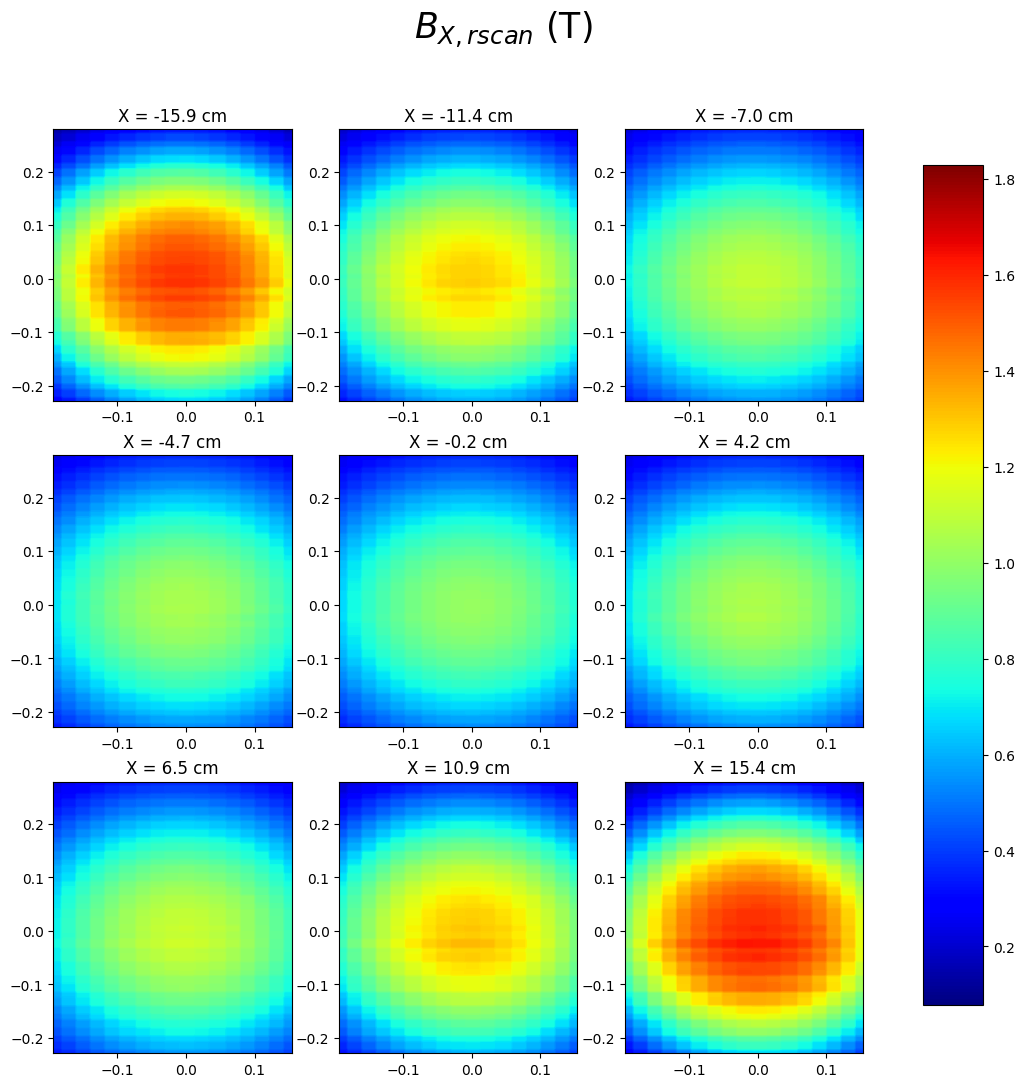

In [11]:
column = 'BX'
title = r'$B_{X,rscan}$ (T)'
section_plot(rscan_df,column,title,interp="nearest")

### Compiling and Executing

In [6]:
%%bash
make -f Makefile.fit clean
make clean
make -f Makefile.fit
make

rm -f src/*.o  FIT_DATA
rm -f src/*.o  BFIELD
g++ -c -Iinclude -lgsl -lgslcblas -std=c++11 -fopenmp src/helix_magnet.cpp -o src/helix_magnet.o
g++ -c -Iinclude -lgsl -lgslcblas -std=c++11 -fopenmp src/coil.cpp -o src/coil.o
g++ -c -Iinclude -lgsl -lgslcblas -std=c++11 -fopenmp src/fit.cpp -o src/fit.o
g++ -o FIT_DATA src/helix_magnet.o src/coil.o src/fit.o -Iinclude -lgsl -lgslcblas -std=c++11 -fopenmp
g++ -c -Iinclude -lgsl -lgslcblas -std=c++11 src/field_calc.cpp -o src/field_calc.o
g++ -o BFIELD src/helix_magnet.o src/coil.o src/field_calc.o -Iinclude -lgsl -lgslcblas -std=c++11


### Note that the BFIELD program can be used to calculate the field at individual coordinates OR for a coordinate file when given a magnet configuration file:

In [7]:
%%bash
./BFIELD magnet_config.csv -c 0 0 0

0.998376	0	0	0.998376


output for coordinate input is: BX BY BZ |B|

In [8]:
%%bash
./BFIELD magnet_config.csv -f data/chicago_format.csv
mv calculated_field.csv calc_nofit.csv

Loaded 10982 points from data/chicago_format.csv...
10982 points remaining...
10482 points remaining...
9982 points remaining...
9482 points remaining...
8982 points remaining...
8482 points remaining...
7982 points remaining...
7482 points remaining...
6982 points remaining...
6482 points remaining...
5982 points remaining...
5482 points remaining...
4982 points remaining...
4482 points remaining...
3982 points remaining...
3482 points remaining...
2982 points remaining...
2482 points remaining...
1982 points remaining...
1482 points remaining...
982 points remaining...
482 points remaining...
Saved values to calculated_field.csv


### Results of the calculated field with no fitting are below

In [9]:
%%bash
less magnet_config.csv

new_coil
current,91.5
width,0.075818
rotation_angleaxis,1.570796326795,0.0,1.0,0.0
origin,-0.359747,0.0,0.0
inner_radius,0.203517,0.215011,0.234632
outer_radius,0.215011,0.234632,0.255224
subcoil_turns,1995.9,5150.0,5489.5
subcoil_rho_div,8,8,8
subcoil_z_div,52,32,32
new_coil
current,91.5
width,0.075818
rotation_angleaxis,1.570796326795,0.0,1.0,0.0
origin,0.359747,0.0,0.0
inner_radius,0.203492,0.214732,0.234709
outer_radius,0.214731,0.234709,0.256222
subcoil_turns,1976.0,5110.0,5486.7
subcoil_rho_div,8,8,8
subcoil_z_div,52,32,32


In [10]:
# read field values calculated using unfitted magnet configuration file
labels_dict = {0:"X",1:"Y",2:"Z",3:"BX",4:"BY",5:"BZ"}
nofit_df = pd.read_csv("calc_nofit.csv",header=None)
nofit_df = nofit_df.rename(index=str, columns=labels_dict)

# add some columns to compare calculated with measured field values
nofit_df['B'] = np.sqrt(nofit_df['BX']*nofit_df['BX']+nofit_df['BY']*nofit_df['BY']+nofit_df['BZ']*nofit_df['BZ'])
nofit_df['DBX'] = nofit_df['BX'] - rscan_df['BX']
nofit_df['DBY'] = nofit_df['BY'] - rscan_df['BY']
nofit_df['DBZ'] = nofit_df['BZ'] - rscan_df['BZ']
nofit_df['DB2'] = nofit_df['DBX']*nofit_df['DBX']+nofit_df['DBY']*nofit_df['DBY']+nofit_df['DBZ']*nofit_df['DBZ']
nofit_df['DB'] = np.sqrt(nofit_df['DB2'])
nofit_df['FRAC'] = nofit_df['DB']/rscan_df['B']
nofit_df['FDBX'] = nofit_df['DBX']/rscan_df['B']
nofit_df['FDBY'] = nofit_df['DBY']/rscan_df['B']
nofit_df['FDBZ'] = nofit_df['DBZ']/rscan_df['B']
nofit_df.describe()

,X,Y,Z,BX,BY,BZ,B,DBX,DBY,DBZ,DB2,DB,FRAC,FDBX,FDBY,FDBZ
count,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000
mean,-0.002488,-0.019733,0.025146,0.851355,-0.001057,0.000975,0.926323,0.009107,-0.010294,0.009558,0.002455,0.042581,0.048597,0.018096,-0.011233,0.010762
std,0.109711,0.106345,0.150415,0.310725,0.223910,0.287941,0.310350,0.034410,0.018984,0.025105,0.003029,0.025333,0.027345,0.040414,0.017982,0.024156
min,-0.181637,-0.193386,-0.228600,0.109504,-0.806827,-0.829164,0.254186,-0.138213,-0.105975,-0.095491,0.000002,0.001503,0.002249,-0.080035,-0.079280,-0.083635
25%,-0.092063,-0.106560,-0.105156,0.622545,-0.112563,-0.160987,0.697899,-0.009260,-0.019699,-0.003135,0.000557,0.023594,0.027931,-0.009636,-0.022635,-0.003424
50%,-0.002488,-0.019733,0.025146,0.828002,-0.000680,0.001214,0.895679,0.010226,-0.008990,0.009135,0.001354,0.036798,0.043125,0.011849,-0.011268,0.011379
75%,0.087086,0.067093,0.155448,1.034027,0.111622,0.159517,1.115745,0.030957,-0.000106,0.020073,0.003052,0.055248,0.063957,0.040606,-0.000129,0.026029
max,0.176661,0.153919,0.278892,1.759284,0.762844,0.828251,1.759422,0.110864,0.070177,0.113332,0.027644,0.166265,0.188833,0.161890,0.057856,0.110836


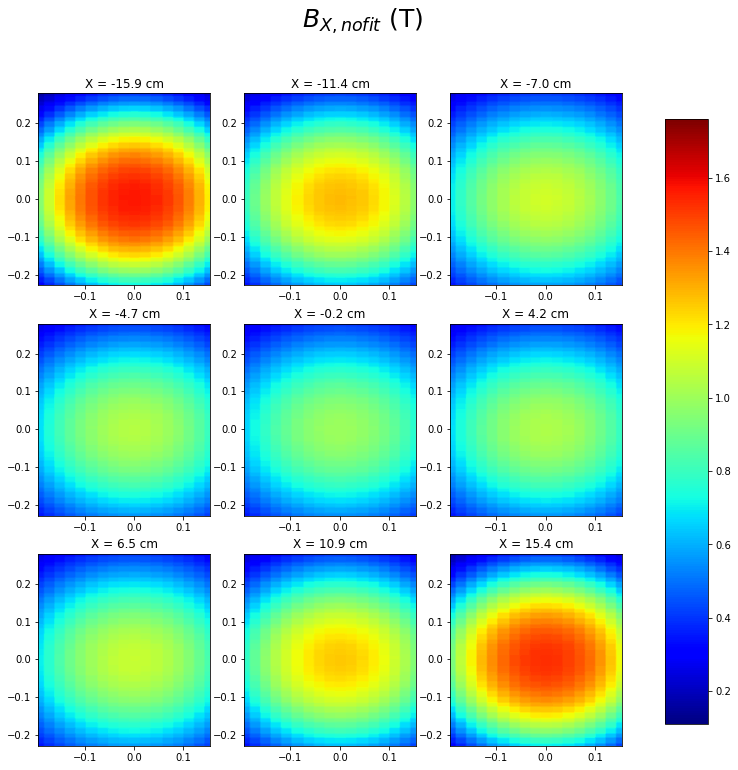

In [11]:
column = 'BX'
title = r'$B_{X,nofit}$ (T)'
section_plot(nofit_df,column,title,interp="nearest")

### Fitting to magnet test data
Below it can be seen how to run a fit for the magnet. The format is './FIT_DATA magnet_config.csv dilution_factor coordinates_file.csv'. I reduced the dilution factor in steps (not shown) until all points from the magnet scan were used.

In [12]:
%%bash
./FIT_DATA magnet_config.csv 100 data/chicago_format.csv

Loaded magnet data from magnet_config.csv ...
------Coil 0------
Current = 91.5 A
Width = 0.075818 m
Rotation Angle = 1.5708 radians
Rotation Axis = (0, 1, 0) 
Origin = (-0.359747, 0, 0) 
Subcoil:       0              1              2              
Turns:         1995.9         5150           5489.5         
Inner Radius:  0.203517       0.215011       0.234632       
Outer Radius:  0.215011       0.234632       0.255224       
Rho Divisions: 8              8              8              
Z Divisions:   52             32             32             
------Coil 1------
Current = 91.5 A
Width = 0.075818 m
Rotation Angle = 1.5708 radians
Rotation Axis = (0, 1, 0) 
Origin = (0.359747, 0, 0) 
Subcoil:       0              1              2              
Turns:         1976           5110           5486.7         
Inner Radius:  0.203492       0.214732       0.234709       
Outer Radius:  0.214731       0.234709       0.256222       
Rho Divisions: 8              8              8              


In [13]:
%%bash
less helix_config_newfit.csv

new_coil
current,91.5
width,0.075818
rotation_angleaxis,1.570807234698217,-0.009611087784709586,0.9999076227248141,0.009611087784708592
origin,-0.3621678082913148,-0.0009433025015490699,0.0005594671349489997
inner_radius,0.2022398671546199,0.2136617387087171,0.2331596107952789
outer_radius,0.2136617387087171,0.2331596107952789,0.2536223895530629
subcoil_turns,1995.9,5150,5489.5
subcoil_rho_div,8,8,8
subcoil_z_div,52,32,32
new_coil
current,91.5
width,0.075818
rotation_angleaxis,1.570828013815432,-0.002573003707485143,0.9999933796300065,0.002573003707484877
origin,0.3496111498888839,0.0004899785937911731,-0.009587993896653074
inner_radius,0.1992574018156484,0.2102635013006793,0.2298247868355957
outer_radius,0.2102625221103336,0.2298247868355957,0.2508901087414201
subcoil_turns,1976,5110,5486.7
subcoil_rho_div,8,8,8
subcoil_z_div,52,32,32


Magnet configuration file with no dilution: helix_config_fitted.csv

In [14]:
%%bash
less helix_config_fitted.csv

new_coil
current,91.5
width,0.075818
rotation_angleaxis,1.570381514159932,0.006311291406169085,0.9999601668074448,-0.006311291406168431
origin,-0.3570241330755666,-0.005845356030904593,5.094722084431961e-05
inner_radius,0.1962736292766629,0.2073585464821345,0.2262812157433628
outer_radius,0.2073585464821345,0.2262812157433628,0.2461403261570631
subcoil_turns,1995.9,5150,5489.5
subcoil_rho_div,8,8,8
subcoil_z_div,52,32,32
new_coil
current,91.5
width,0.075818
rotation_angleaxis,1.570579546934161,0.00151963059283926,0.9999976907201948,-0.001519630592839103
origin,0.3482921329327381,-0.0007180087020030899,-0.005737567305902048
inner_radius,0.1961598448054855,0.2069948489118565,0.2262520443774237
outer_radius,0.2069938849435197,0.2262520443774237,0.2469898952084166
subcoil_turns,1976,5110,5486.7
subcoil_rho_div,8,8,8
subcoil_z_div,52,32,32


In [15]:
%%bash
./BFIELD helix_config_fitted.csv -f data/chicago_format.csv
mv calculated_field.csv calc_fit.csv

Loaded 10982 points from data/chicago_format.csv...
10982 points remaining...
10482 points remaining...
9982 points remaining...
9482 points remaining...
8982 points remaining...
8482 points remaining...
7982 points remaining...
7482 points remaining...
6982 points remaining...
6482 points remaining...
5982 points remaining...
5482 points remaining...
4982 points remaining...
4482 points remaining...
3982 points remaining...
3482 points remaining...
2982 points remaining...
2482 points remaining...
1982 points remaining...
1482 points remaining...
982 points remaining...
482 points remaining...
Saved values to calculated_field.csv


In [16]:
fit_df = pd.read_csv("calc_fit.csv",header=None)
fit_df = fit_df.rename(index=str, columns=labels_dict)
fit_df['B'] = np.sqrt(fit_df['BX']*fit_df['BX']+fit_df['BY']*fit_df['BY']+fit_df['BZ']*fit_df['BZ'])
fit_df['DBX'] = fit_df['BX'] - rscan_df['BX']
fit_df['DBY'] = fit_df['BY'] - rscan_df['BY']
fit_df['DBZ'] = fit_df['BZ'] - rscan_df['BZ']
fit_df['DB2'] = fit_df['DBX']*fit_df['DBX']+fit_df['DBY']*fit_df['DBY']+fit_df['DBZ']*fit_df['DBZ']
fit_df['DB'] = np.sqrt(fit_df['DB2'])
fit_df['FRAC'] = fit_df['DB']/rscan_df['B']
fit_df['FDBX'] = fit_df['DBX']/rscan_df['B']
fit_df['FDBY'] = fit_df['DBY']/rscan_df['B']
fit_df['FDBZ'] = fit_df['DBZ']/rscan_df['B']
fit_df.describe()

,X,Y,Z,BX,BY,BZ,B,DBX,DBY,DBZ,DB2,DB,FRAC,FDBX,FDBY,FDBZ
count,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,1.098200e+04,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000
mean,-0.002488,-0.019733,0.025146,0.841063,0.008626,-0.006653,0.923901,-0.001185,-0.000611,0.001931,5.455487e-04,0.019483,0.021093,-0.001207,-0.000130,0.002125
std,0.109711,0.106345,0.150415,0.329603,0.235817,0.300438,0.329256,0.014951,0.012341,0.012816,7.941487e-04,0.012884,0.011154,0.014988,0.012191,0.013789
min,-0.181637,-0.193386,-0.228600,0.066571,-0.801205,-0.862916,0.234136,-0.082430,-0.069298,-0.043860,1.562986e-07,0.000395,0.000530,-0.059115,-0.056584,-0.050135
25%,-0.092063,-0.106560,-0.105156,0.599442,-0.110431,-0.176329,0.681660,-0.010108,-0.006946,-0.005102,1.083131e-04,0.010407,0.013102,-0.011190,-0.007783,-0.006359
50%,-0.002488,-0.019733,0.025146,0.814387,0.006795,-0.005937,0.888728,-0.001374,-0.000431,0.000819,2.645209e-04,0.016264,0.019066,-0.001583,-0.000563,0.001016
75%,0.087086,0.067093,0.155448,1.032269,0.125861,0.159928,1.123078,0.006652,0.005755,0.008690,6.282535e-04,0.025065,0.027147,0.008546,0.007318,0.009833
max,0.176661,0.153919,0.278892,1.808108,0.854347,0.861457,1.808200,0.087465,0.064188,0.067038,8.774996e-03,0.093675,0.080191,0.053806,0.053205,0.065308


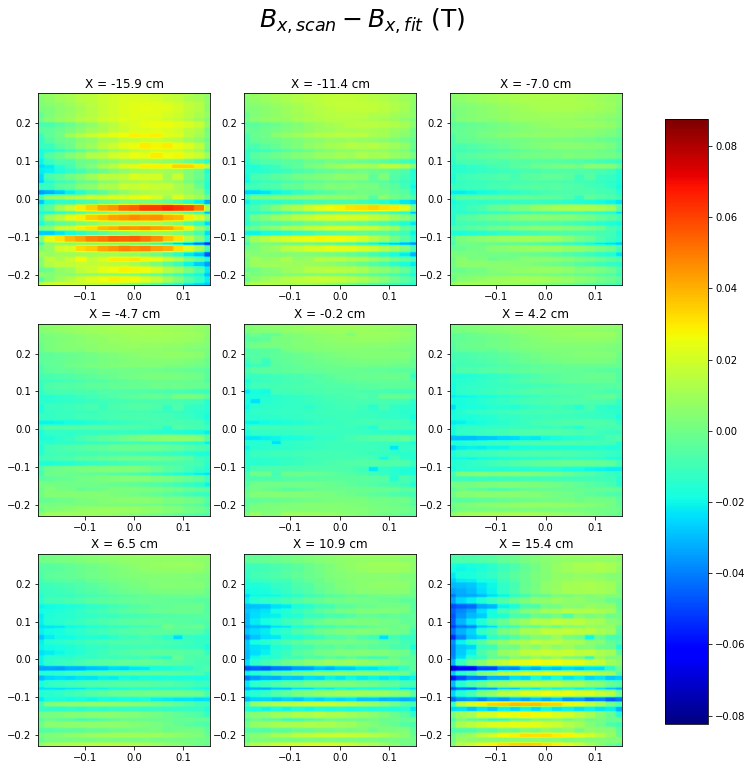

In [17]:
column = 'DBX'
title = r'$B_{x,scan}-B_{x,fit}$ (T)'
section_plot(fit_df,column,title,interp="nearest")

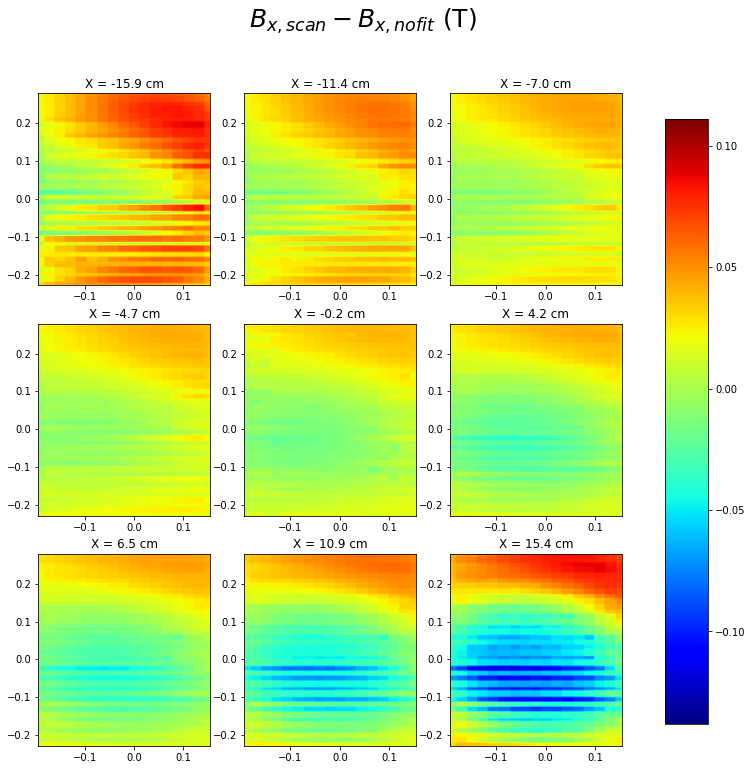

In [18]:
column = 'DBX'
title = r'$B_{x,scan}-B_{x,nofit}$ (T)'
section_plot(nofit_df,column,title,interp="nearest")

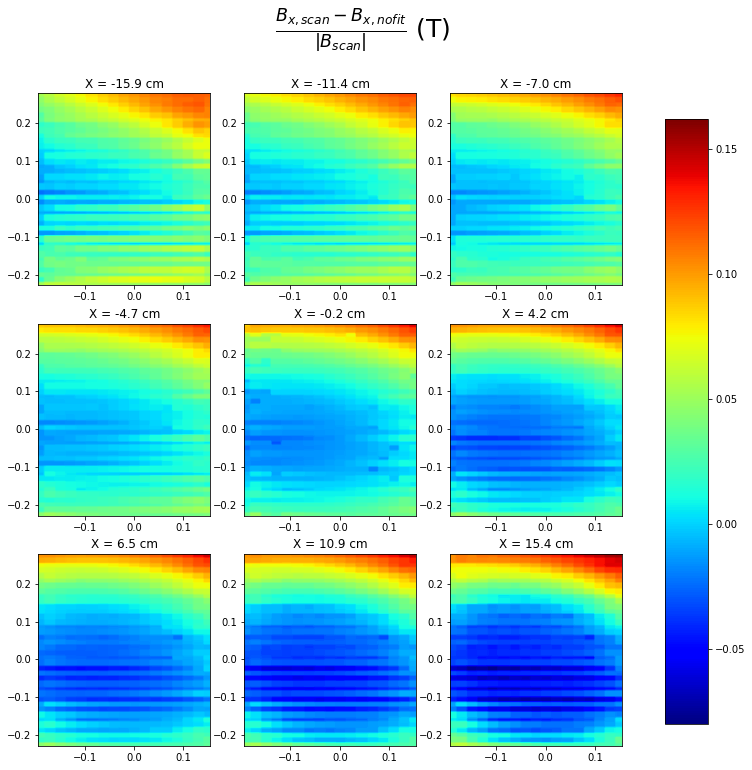

In [19]:
column = 'FDBX'
title = r'$\frac{B_{x,scan}-B_{x,nofit}}{|B_{scan}|}$ (T)'
section_plot(nofit_df,column,title,interp="nearest")

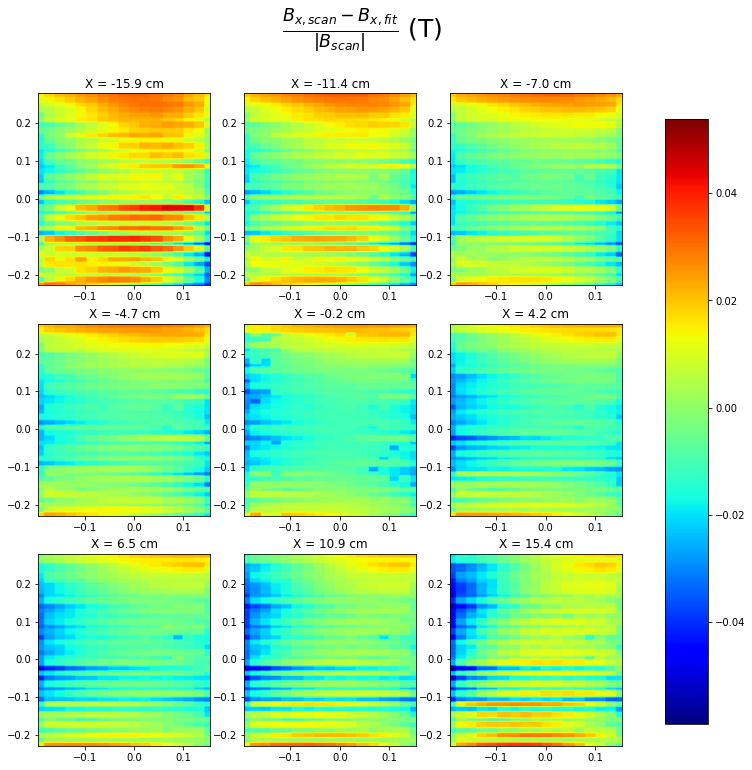

In [20]:
column = 'FDBX'
title = r'$\frac{B_{x,scan}-B_{x,fit}}{|B_{scan}|}$ (T)'
section_plot(fit_df,column,title,interp="nearest")

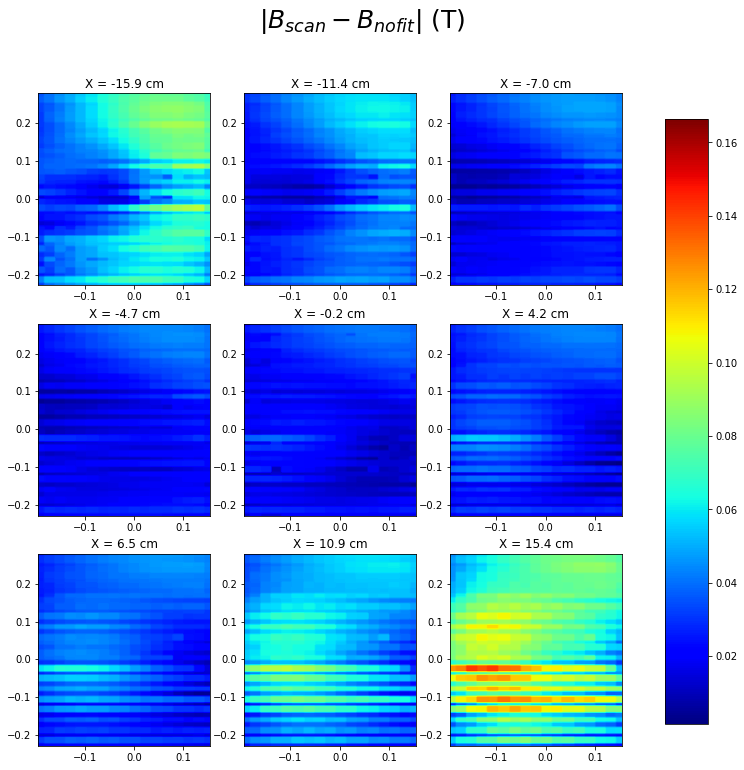

In [21]:
column = 'DB'
title = r'$|B_{scan}-B_{nofit}|$ (T)'
section_plot(nofit_df,column,title,interp="nearest")

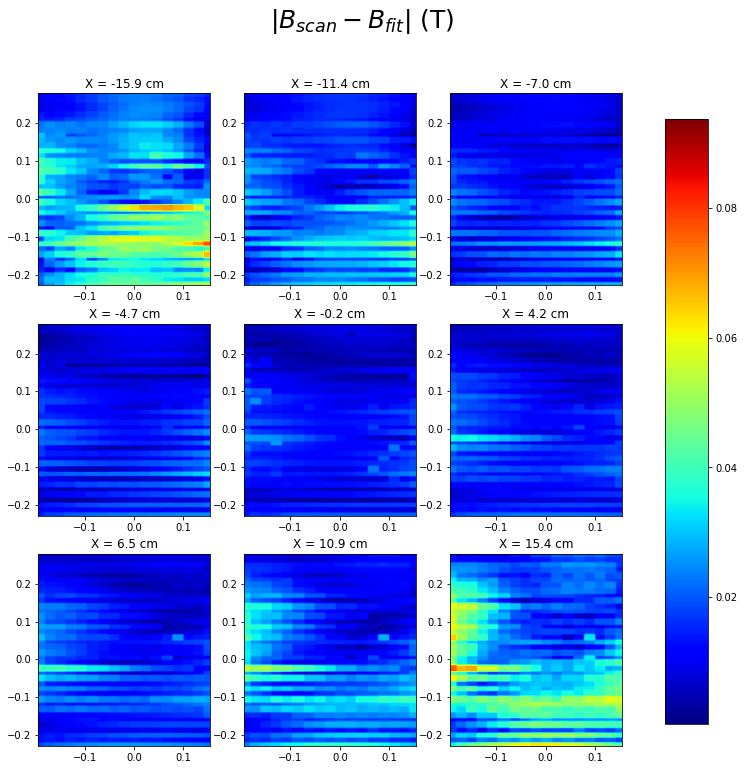

In [22]:
column = 'DB'
title = r'$|B_{scan}-B_{fit}|$ (T)'
section_plot(fit_df,column,title,interp="nearest")

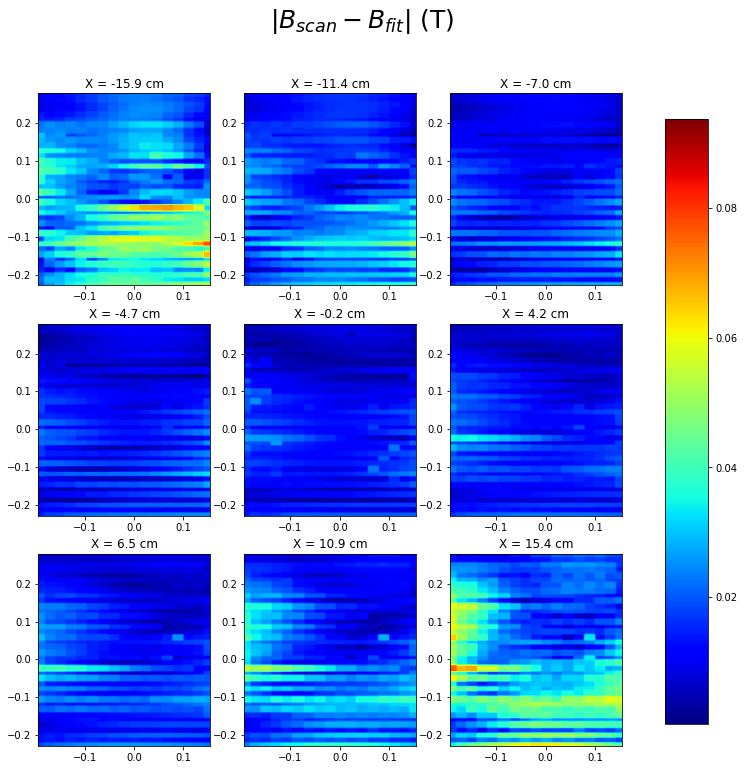

In [23]:
column = 'DB'
title = r'$|B_{scan}-B_{fit}|$ (T)'
section_plot(fit_df,column,title,interp="nearest")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36bad7b518>]],
      dtype=object)

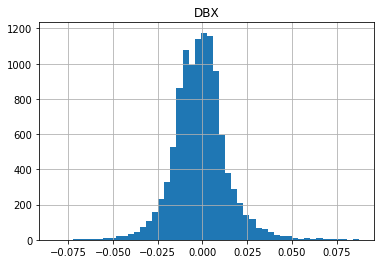

In [24]:
fit_df.hist(column='DBX',bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36bad899e8>]],
      dtype=object)

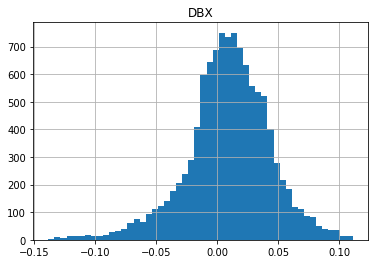

In [25]:
nofit_df.hist(column='DBX',bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36b3dd8ba8>]],
      dtype=object)

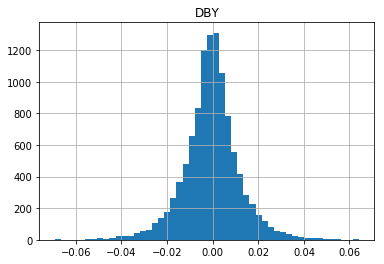

In [26]:
fit_df.hist(column='DBY',bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36b3a72978>]],
      dtype=object)

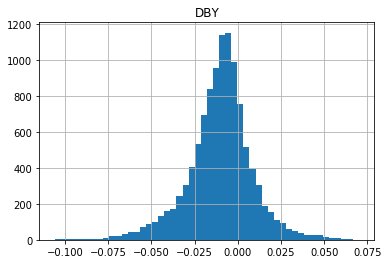

In [27]:
nofit_df.hist(column='DBY',bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36bb01fa58>]],
      dtype=object)

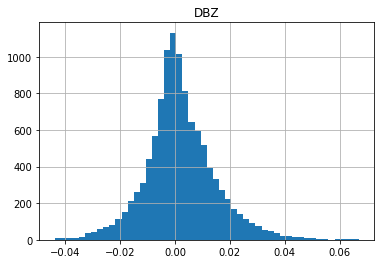

In [28]:
fit_df.hist(column='DBZ',bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36b3a1e2b0>]],
      dtype=object)

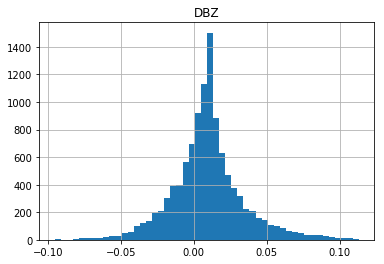

In [29]:
nofit_df.hist(column='DBZ',bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36b3f95550>]],
      dtype=object)

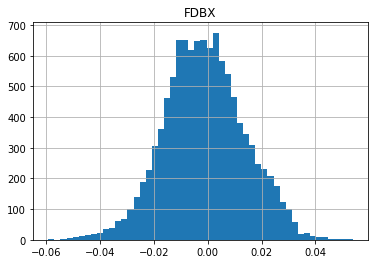

In [30]:
fit_df.hist(column='FDBX',bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36bad3aa58>]],
      dtype=object)

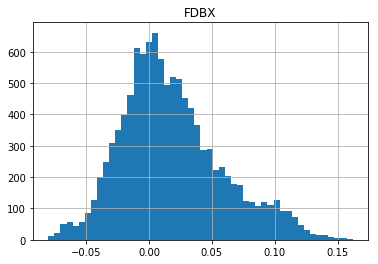

In [31]:
nofit_df.hist(column='FDBX',bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36bb4d1160>]],
      dtype=object)

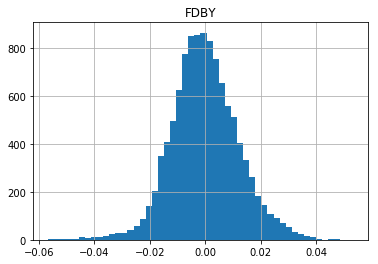

In [32]:
fit_df.hist(column='FDBY',bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36e0106f60>]],
      dtype=object)

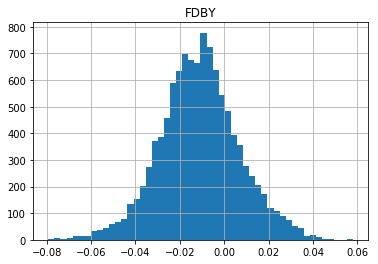

In [33]:
nofit_df.hist(column='FDBY',bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36bb7f2860>]],
      dtype=object)

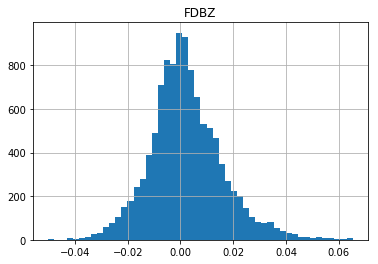

In [34]:
fit_df.hist(column='FDBZ',bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36b39e5860>]],
      dtype=object)

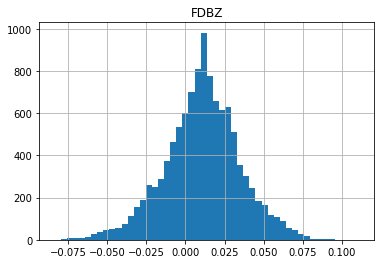

In [35]:
nofit_df.hist(column='FDBZ',bins=50)